# Import Libraries

In [ ]:
# Package Installing

!pip3 install -q nltk

In [ ]:
from google.colab import drive
drive.mount('/content/Mydrive')

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


In [ ]:
cd Mydrive/MyDrive/Colab_Notebooks/Projects/My-Task

/content/Mydrive/MyDrive/Colab_Notebooks/Projects/My-Task


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re
import random
import pickle


from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

from sentiment_analysis_helper_functions import construct_encodings, construct_tfdataset, create_predictor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing

In [ ]:
senti_data = pd.read_csv('senti_data.csv')

In [ ]:
senti_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2221 non-null   object
 1   sentiment  2221 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.8+ KB


In [ ]:
senti_data.nunique()

text         2221
sentiment       2
dtype: int64

In [ ]:
senti_data.sentiment.value_counts()

1    1197
0    1024
Name: sentiment, dtype: int64

In [ ]:
# Positive Sentiment
print(*senti_data.loc[senti_data.sentiment == 1, 'text'].sample(5),sep = '\n' + '-' * 10 + '\n')

a beautiful cat eating some grass as another looks on intently
----------
A small red and white train passing by while happy people take pictures of it.
----------
a train driving down the tracks near trees and a pretty building
----------
a interesting photo of a beautiful woman standing on a skateboard with her arms outstretched
----------
a happy man looks through the hole of a large doughnut


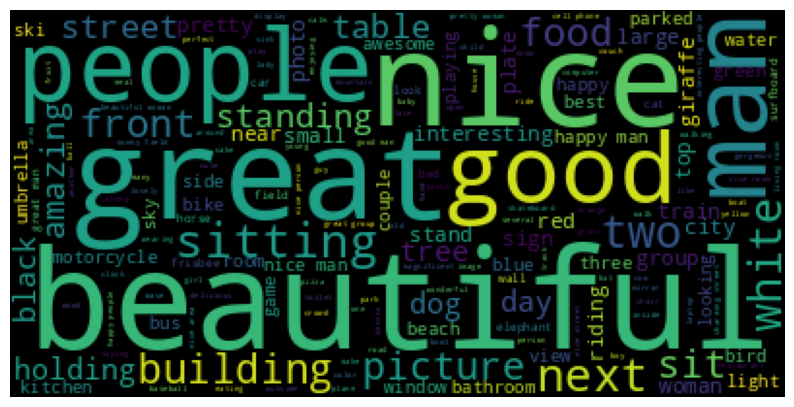

In [ ]:
wc = WordCloud(stopwords=stopwords.words('english') + list(string.punctuation)).generate(' '.join(senti_data.loc[senti_data.sentiment == 1, 'text']))

plt.figure(figsize = (10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
# Negative Sentiment
print(*senti_data.loc[senti_data.sentiment == 0, 'text'].sample(5),sep = '\n' + '-' * 10 + '\n')

bad boy with a bright blue shirt and bow tie sitting in a seat.
----------
There are only a few stupid people that are at this beach.
----------
The crappy photo is of a game of baseball where the batter is up to bat.
----------
A really weird lady is in a dirty house playing with some poor dogs on her sofa.
----------
one of those signs must read warning unpaved road ahead


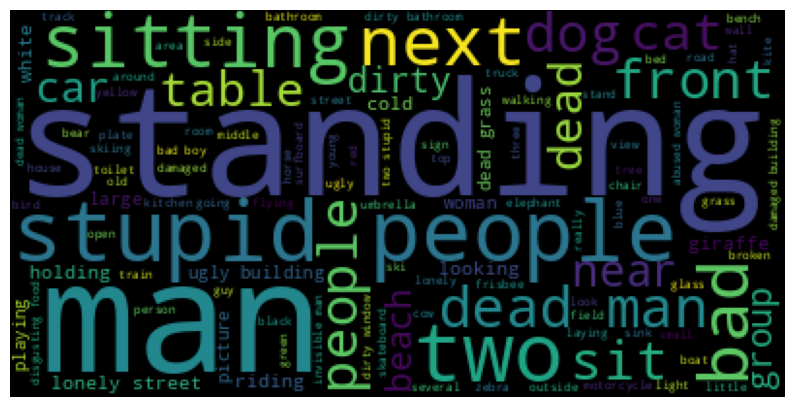

In [ ]:
wc = WordCloud(stopwords=stopwords.words('english') + list(string.punctuation)).generate(' '.join(senti_data.loc[senti_data.sentiment == 0, 'text']))

plt.figure(figsize = (10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

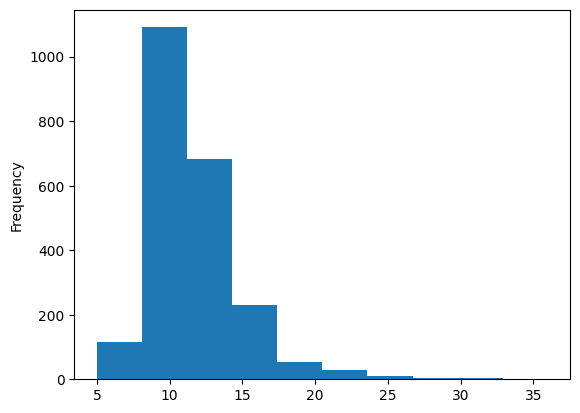

In [ ]:
senti_data['text'].apply(lambda x : len(x.split())).plot.hist()
plt.show()

In [ ]:
senti_data['text'].apply(lambda x : len(x.split())).max()

36

In [ ]:
general_stopwords = stopwords.words('english')
general_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [ ]:
lemmatizer =  WordNetLemmatizer()

def text_preprocessing(text):

  text = text.lower()
  text = re.sub(r"[^\w\s]", ' ', text)
  tokens = word_tokenize(text)

  pr_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens if token not in general_stopwords])

  return pr_text

In [ ]:
print(*senti_data['text'][:3],
      sep = '\n')

The giraffes had caused a broken window earlier that  day.
A woman stands in the dining area at the table with comfy chairs.
A horrible picture of a computer on white desk


In [ ]:
print(*senti_data['text'].apply(text_preprocessing)[:3],
      sep = '\n')

giraffe caused broken window earlier day
woman stand dining area table comfy chair
horrible picture computer white desk


In [ ]:
senti_data['text_cleaned'] = senti_data['text'].apply(text_preprocessing)

In [ ]:
senti_data.head()

,text,sentiment,text_cleaned
0,The giraffes had caused a broken window earlie...,0,giraffe caused broken window earlier day
1,A woman stands in the dining area at the table...,0,woman stand dining area table comfy chair
2,A horrible picture of a computer on white desk,0,horrible picture computer white desk
3,A weird guy on a ramp riding a skateboard,0,weird guy ramp riding skateboard
4,"THE ELEPHANTS ARE APPROACHING A ""DIRTY WATER"" ...",0,elephant approaching dirty water source


# Sentiment Analysis | Fine-Tuning

## Loading the Model

In [ ]:
checkpoint = 'distilbert-base-uncased'
MAX_LEN = 36

tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Preprocessing the Inputs

In [ ]:
X = senti_data['text_cleaned']
y = senti_data['sentiment']

In [ ]:
# construct encodings
encodings = construct_encodings(X.to_list(), tokenizer, max_len=MAX_LEN)

In [ ]:
# construct tensorflow dataset
tfdataset = construct_tfdataset(encodings, y)

## Training

In [ ]:
TEST_SIZE = .2
BATCH_SIZE = 2

train_size = int(len(X) * (1-TEST_SIZE))

tfdataset = tfdataset.shuffle(len(X))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test  = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)


In [ ]:
EPOCHS = 5

model = TFDistilBertForSequenceClassification.from_pretrained(checkpoint)
model.compile(optimizer=optimizers.Adam(learning_rate=3e-5),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])
history_model = model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5
888/888 [==============================] - 1198s 1s/step - loss: 0.1125 - acc: 0.9595
Epoch 2/5
888/888 [==============================] - 1162s 1s/step - loss: 0.0488 - acc: 0.9870
Epoch 3/5
888/888 [==============================] - 1119s 1s/step - loss: 0.0148 - acc: 0.9983
Epoch 4/5
888/888 [==============================] - 1127s 1s/step - loss: 0.0178 - acc: 0.9961
Epoch 5/5
888/888 [==============================] - 1111s 1s/step - loss: 0.0259 - acc: 0.9932


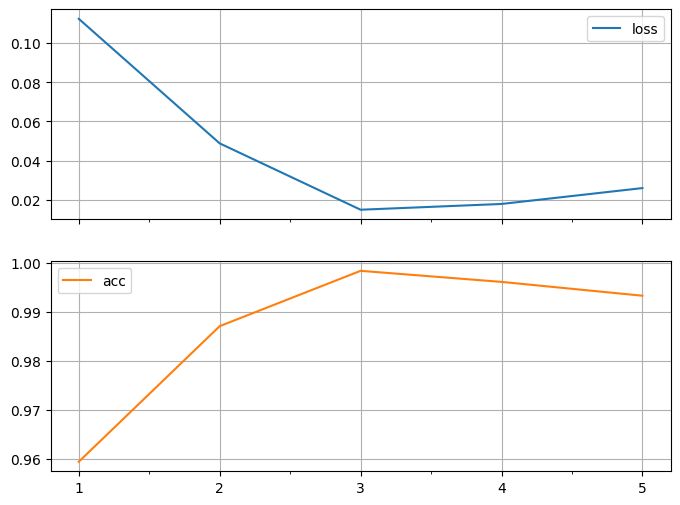

In [ ]:
# Training Evaluation
pd.DataFrame(history_model.history).plot(subplots = True, figsize = (8,6), grid = True)
plt.xticks(ticks = range(5), labels = range(1,6))
plt.show()

In [ ]:
# Test Evaluation
print(evaluation := model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE))

223/223 [==============================] - 30s 127ms/step - loss: 0.0164 - acc: 0.9955
{'loss': 0.016366276890039444, 'acc': 0.9955056309700012}


In [ ]:
#@title Model Inference
clf = create_predictor(model, tokenizer, checkpoint, MAX_LEN)
print(clf('this restaurant has great food'))

1/1 [==============================] - 2s 2s/step
1


In [ ]:
#@title Save the Fine_tuned Model

model.save_pretrained('./Sentiment_Analysis_Fine_Tuned/sentiment_analysis_clf')
with open('./Sentiment_Analysis_Fine_Tuned/sentiment_analysis_clf_info.pkl', 'wb') as f:
  pickle.dump((checkpoint, MAX_LEN), f)